<a href="https://colab.research.google.com/github/ReynardAdimas/Asah/blob/main/Reynard_Adimas_Nabil_Template_Submission_Akhir_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Reynard Adimas Nabil
- **Email:** m297d5y1692@student.devacademy.id
- **ID Dicoding:** M297D5Y1692

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [2]:
!pip install -q kaggle
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable 

### Data Preprocessing

In [4]:
import os
import shutil

train_dir = "Vegetable Images/train"
test_dir = "Vegetable Images/test"
validation_dir = "Vegetable Images/validation"

combined_dir = "Vegetable Images/dataset"

os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(validation_dir):
  category_dir = os.path.join(validation_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

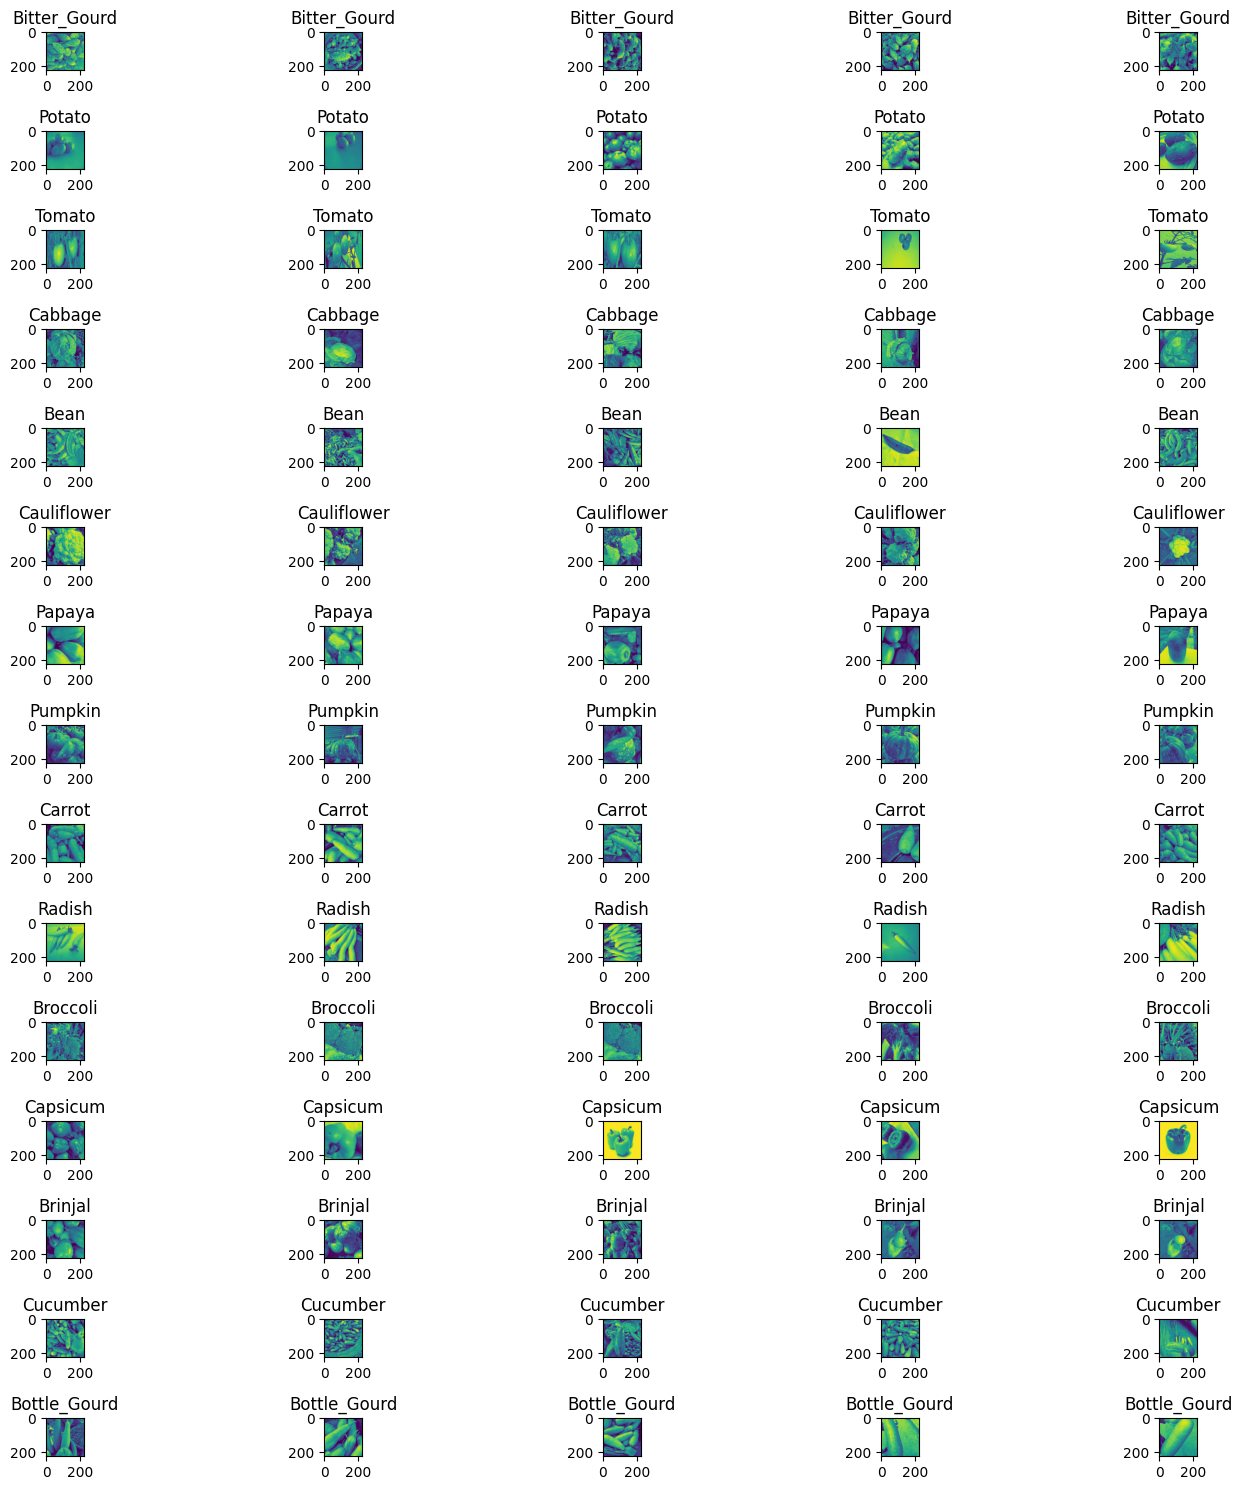

In [8]:
# Dataset Checking
vegetable_image = {}

path = "Vegetable Images/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  vegetable_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "Vegetable Images/dataset/"

fig, axes = plt.subplots(len(vegetable_image.keys()), 5, figsize=(15,15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(vegetable_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("L")
    axes[i, j].imshow(img)
    axes[i, j].set_title(class_name)



fig.tight_layout()

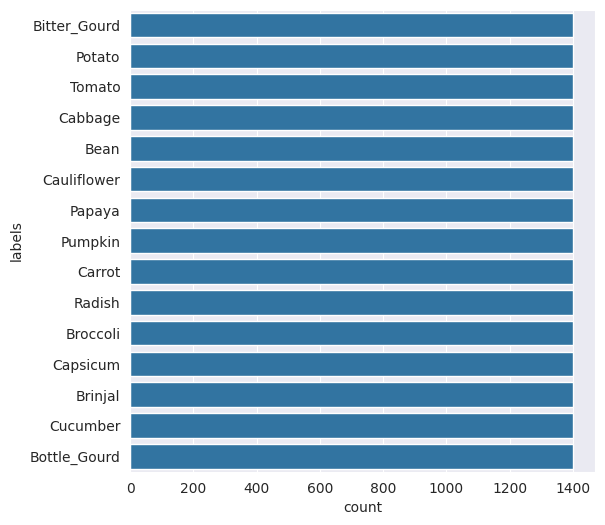

In [9]:
# Plot Distribusi
vegetable_path = "Vegetable Images/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(vegetable_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path" : full_path, "file_name" : file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [10]:
mypath = "Vegetable Images/dataset/"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({"path" : full_path, "file_name" : file_name, "labels":labels})
df.groupby(['labels']).size()



,0
labels,
Bean,1400
Bitter_Gourd,1400
Bottle_Gourd,1400
Brinjal,1400
Broccoli,1400
Cabbage,1400
Capsicum,1400
Carrot,1400
Cauliflower,1400


## Modelling

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)